In [3]:
import json, sys
from collections import Counter
from pathlib import Path
from typing import Callable

from pandas import Index
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append("/mnt/data/datasets/LSA-T")
from helpers.visualization import save_fig
from type_hints import CutData


plt.style.use("ggplot")
plt.rcParams.update({'font.size': 18})
color="dodgerblue"
figs_path = Path("./plots/samples")
figs_path.mkdir(exist_ok=True)

def clean_word(word: str, chars: list[str], rep: str = '') -> str:
    for c in chars:
        word = word.replace(c,rep)
    return word

inv_chars = ['\n', ',', '.', '"', '-', '?', '!', '¿', '¡', '_']

# cuts data contains list of data for each cut json file
cuts_data: list[CutData] = []
# words contain list of words for each cut, excepting stopwords
words: dict[str, list[str]] = {}
# times contain lenght (s) for each cut
times: dict[str, float] = {}
# videos contains videos names
videos: set[str] = set()

path = Path("../data/cuts/")
cuts = map(lambda p: Path(str(p.resolve())[:-3] + "json"), path.glob('**/*.mp4'))

for idx, cut in enumerate(cuts):
    with cut.open() as datafile:
        data: CutData = json.load(datafile)
    cuts_data.append(data)
    words[str(cut)] = [w for w in clean_word(data['label'], inv_chars, ' ').lower().split(' ') if w]
    times[str(cut)] = (data['end'] - data['start'])
    videos.add(data['video'])

print(f'''La base de datos contiene:
    {len(videos)} videos completos
    {len(cuts_data)} clips resultantes de dividir los videos de acuerdo a los subtítulos
    {(sum(times.values())/60)/60} hs de video''')

La base de datos contiene:
    64 videos completos
    14880 clips resultantes de dividir los videos de acuerdo a los subtítulos
    21.78172527777782 hs de video


Estadísticas de la duración de los clips:

count    14880.000000
mean         5.269772
std          2.732944
min          0.450000
25%          3.330000
50%          4.670000
75%          6.540000
max         25.580000
dtype: float64

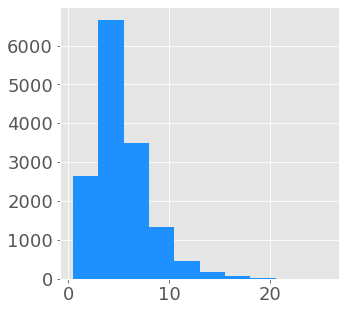

In [11]:
clip_times_s = pd.Series(times)
display(clip_times_s.describe())
clip_times_hist_fig = clip_times_s.plot.hist(figsize=(5,5), color="dodgerblue")
clip_times_hist_fig.set_ylabel("")
save_fig(clip_times_hist_fig, "hist_times_per_vid.png", figs_path)

Estadísticas de cantidad de palabras por clip:

count    14880.000000
mean         9.151277
std          3.294274
min          1.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         25.000000
dtype: float64

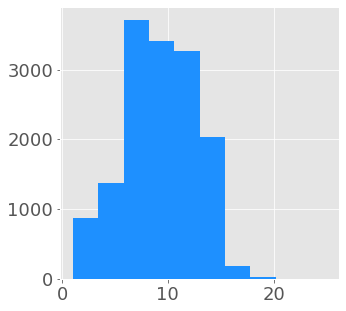

In [12]:
words_per_vid_s = pd.Series({k: len(v) for k, v in words.items()})
display(words_per_vid_s.describe())
words_per_vid_fig = words_per_vid_s.plot.hist(figsize=(5, 5), color="dodgerblue")
words_per_vid_fig.set_ylabel("")
save_fig(words_per_vid_fig, "hist_words_per_vid.png", figs_path)

Estadísticas sobre palabras por frecuencia

count    14238.000000
mean         9.563913
std        113.766985
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       7595.000000
dtype: float64

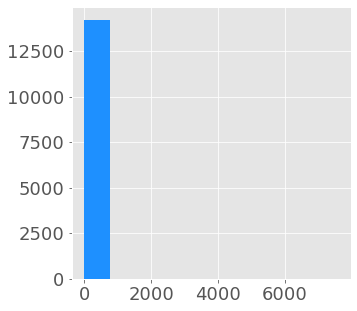

In [4]:
total_words = [word for label in words.values() for word in label]
word_count = Counter(total_words)

words_hist_s = pd.Series([f for _, f in word_count.items()])
display(words_hist_s.describe())
words_hist_fig = words_hist_s.hist(figsize=(5, 5), color=color)
words_hist_fig.set_ylabel("")
save_fig(words_hist_fig, "hist_words_freq.png", figs_path)

count      10.000000
mean     1423.800000
std      2123.763525
min       162.000000
25%       271.750000
50%       598.500000
75%      1442.750000
max      7150.000000
dtype: float64

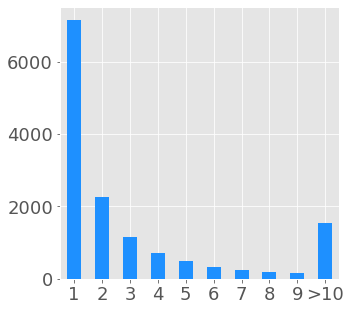

In [27]:
def get_sort_key(other_symbol: str, other_val: int) -> Callable[[Index], list[int]]:
    def sort_key(i: Index) -> list[int]:
        return list(map(lambda i: int(i) if i != other_symbol else other_val, i))
    return sort_key

def word_freqs_range(word_count: dict[str,int], group_key: Callable[[int], bool], other_symbol: str) -> Counter[str]:
    return Counter([(str(v) if not group_key(v) else other_symbol) for (_,v) in word_count.items()])

max_freq = 10
words_hist_range_max = word_freqs_range(word_count, lambda v: v>=max_freq, f">{max_freq}")
words_hist_range_max_s = pd.Series(words_hist_range_max).sort_index(key=get_sort_key(f">{max_freq}", max_freq))

display(words_hist_range_max_s.describe())
words_hist_range_max_fig = words_hist_range_max_s.plot.bar(figsize=(5, 5), color=color)
words_hist_range_max_fig.set_ylabel("")
plt.xticks(rotation=360)
save_fig(words_hist_range_max_fig, f"hist_words_freq_grouped_gt{10}.png", figs_path)

count      10.000000
mean      651.100000
std       565.705744
min       109.000000
25%       210.500000
50%       402.000000
75%      1008.000000
max      1673.000000
dtype: float64

<AxesSubplot:>

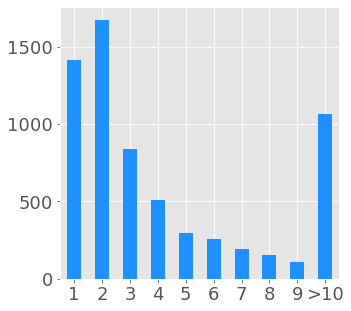

In [26]:
singletons = [word for word, freq in word_count.items() if freq <= 1]
labels_no_sing = [label for label in words.values() if (not any(((word in singletons) for word in label)))]
word_count_no_sing = Counter([word for label in labels_no_sing for word in label])

words_hist_no_sing_range_max = word_freqs_range(word_count_no_sing, lambda v: v>=max_freq, f">{max_freq}")
words_hist_no_sing_range_max_s = pd.Series(words_hist_no_sing_range_max).sort_index(key=get_sort_key(f">{max_freq}", max_freq))

display(words_hist_no_sing_range_max_s.describe())
words_hist_no_sing_range_max_fig = words_hist_no_sing_range_max_s.plot.bar(figsize=(5, 5), color=color)
words_hist_no_sing_range_max_fig.set_ylabel("")
plt.xticks(rotation=360)
display(words_hist_no_sing_range_max_fig)
save_fig(words_hist_no_sing_range_max_fig, f"hist_words_freq_no_sing_grouped_gt{max_freq}.png", figs_path)

count     10.000000
mean     229.000000
std      154.785156
min       59.000000
25%       96.500000
50%      201.500000
75%      314.750000
max      530.000000
dtype: float64

<AxesSubplot:>

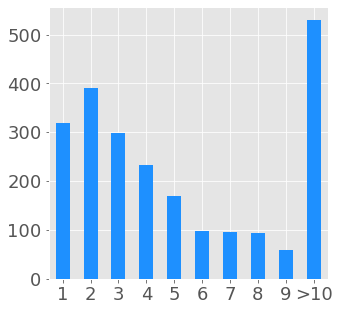

In [25]:
lt5_tokens = [word for word, freq in word_count.items() if freq <= 5]
labels_no_lt5 = [label for label in words.values() if (not any(((word in lt5_tokens) for word in label)))]
word_count_no_lt5 = Counter([word for label in labels_no_lt5 for word in label])

words_hist_no_lt5_range_max = word_freqs_range(word_count_no_lt5, lambda v: v>=max_freq, f">{max_freq}")
words_hist_no_lt5_range_max_s = pd.Series(words_hist_no_lt5_range_max).sort_index(key=get_sort_key(f">{max_freq}", max_freq))

display(words_hist_no_lt5_range_max_s.describe())
words_hist_no_lt5_range_max_fig = words_hist_no_lt5_range_max_s.plot.bar(figsize=(5, 5), color=color)
words_hist_no_lt5_range_max_fig.set_ylabel("")
plt.xticks(rotation=360)
display(words_hist_no_lt5_range_max_fig)
save_fig(words_hist_no_lt5_range_max_fig, f"hist_words_freq_no_lt5_grouped_gt{max_freq}.png", figs_path)

count    113114.000000
mean          1.203839
std           1.524150
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         192.000000
dtype: float64

<AxesSubplot:>

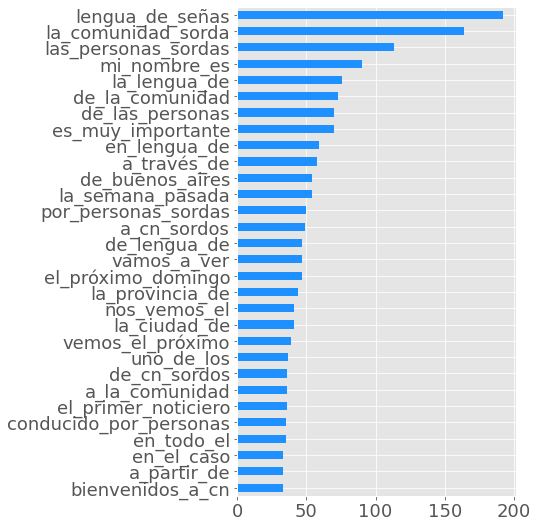

In [ ]:
total_trigrams = ['_'.join(total_words[i:i + 3]) for i in range(len(total_words))]
trigram_count = Counter(total_trigrams)

total_trigrams_s = pd.Series(trigram_count).sort_values(ascending=False)
display(total_trigrams_s.describe())
display(total_trigrams_s.iloc[:30].sort_values().plot.barh(figsize=(5,9), color=color))

Estadísticas acerca de palabras mas frecuentes:

count    14238.000000
mean         9.563913
std        113.766985
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       7595.000000
dtype: float64

<AxesSubplot:>

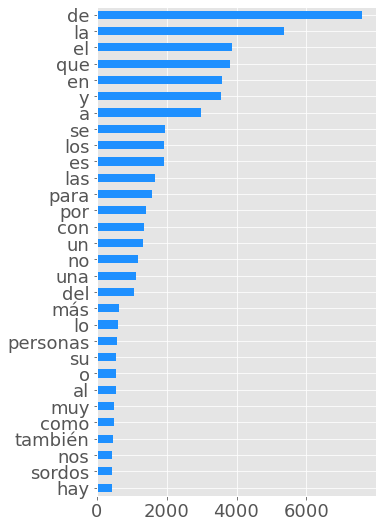

In [15]:
n_to_show = 30

words_freq_s = pd.Series(word_count).sort_values(ascending=False)
display(words_freq_s.describe())
words_freq_fig = words_freq_s.iloc[:n_to_show].sort_values().plot.barh(figsize=(5,9), color=color)
display(words_freq_fig)
save_fig(words_freq_fig, f"bar_{n_to_show}_most_common_words_freq.png", figs_path)

count    70809.000000
mean         1.923075
std          7.558147
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1029.000000
dtype: float64

<AxesSubplot:>

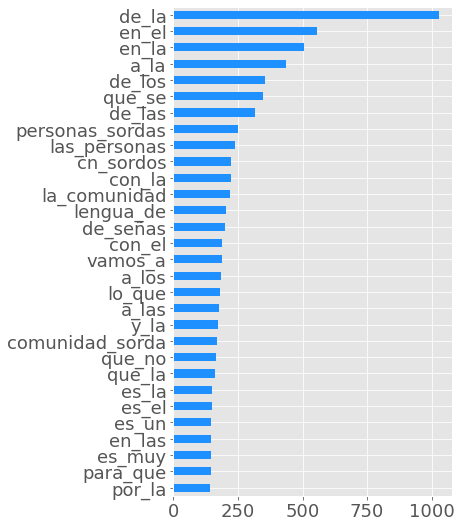

In [16]:
total_bigrams = ['_'.join(total_words[i:i + 2]) for i in range(len(total_words))]
bigram_count = Counter(total_bigrams)

bigrams_freq_s = pd.Series(bigram_count).sort_values(ascending=False)
display(bigrams_freq_s.describe())
bigrams_freq_fig = bigrams_freq_s.iloc[:n_to_show].sort_values().plot.barh(figsize=(5,9), color=color)
display(bigrams_freq_fig)
save_fig(bigrams_freq_fig, f"bar_{n_to_show}_most_common_bigrams_freq.png", figs_path)

count    113114.000000
mean          1.203839
std           1.524150
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         192.000000
dtype: float64

<AxesSubplot:>

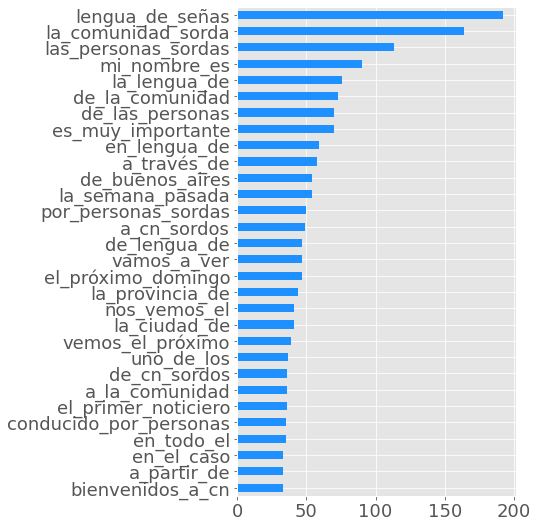

In [17]:
total_trigrams = ['_'.join(total_words[i:i + 3]) for i in range(len(total_words))]
trigram_count = Counter(total_trigrams)

trigrams_freq_s = pd.Series(trigram_count).sort_values(ascending=False)
display(trigrams_freq_s.describe())
trigrams_freq_fig = trigrams_freq_s.iloc[:30].sort_values().plot.barh(figsize=(5,9), color=color)
display(trigrams_freq_fig)
save_fig(trigrams_freq_fig, f"bar_{n_to_show}_most_common_trigrams_freq.png", figs_path)

Cantidad de clips por playlists

count        4.000000
mean      3720.000000
std       6659.176125
min         44.000000
25%         99.500000
50%        575.000000
75%       4195.500000
max      13686.000000
dtype: float64

<AxesSubplot:>

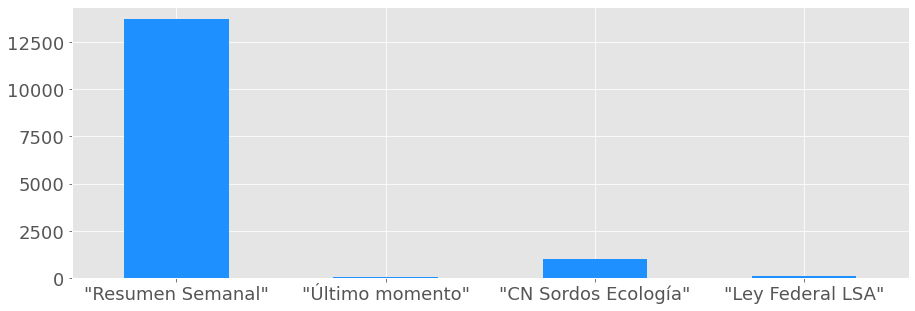

In [18]:
playlists_names = {
    'resumen_semanal': '"Resumen Semanal"',
    'ultimo_momento': '"Último momento"',
    'ecologia': '"CN Sordos Ecología"',
    'ley_federal_lsa': '"Ley Federal LSA"'
}

playlist_s: pd.Series = pd.Series(Counter(map(lambda cd: playlists_names[cd['playlist']], cuts_data)))
display(playlist_s.describe())
playlists_fig = playlist_s.plot.bar(figsize=(15,5), color=color)
plt.xticks(rotation=0)
display(playlists_fig)
save_fig(playlists_fig, "hist_videos_by_playlists.png", figs_path)